In [1]:
from sklearn.linear_model import LinearRegression
import math
from itertools import product
from scipy.special import legendre 
from scipy.special import hermitenorm
from sklearn.metrics import mean_squared_error
import sys
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aPCE import *
from AFVB_PCE import *
from VRVM_PCE import *

In [2]:
import scipy.integrate as integrate
import scipy.special as special
import time

In [3]:
## Directory where I want the plots saved
wd = '/Users/chave/Desktop/Thesis Files/Thesis Proposal/Thesis_Proposal_Written'

# Basis Functions

In [4]:
def basis_aPCE(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)

    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  mod.Pol_eval(P[j][idx[i][j]], Z[:,j])
            
    return Phi

In [5]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

# Results Function

In [6]:
def GSA(a, idx, active_cols):
    
    V = np.sum(a[1:]**2)
    V_Partial = []
    V_Total = []
    S_Partial = []
    S_Total = []
    
    l = [0,1,2]
    
    for k in range(d):
        l = list(range(d))
        l.remove(k)
        
        temp = np.full(idx[active_cols].shape[0], True, dtype = bool)
        
        for i in range(idx[active_cols].shape[0]):
            temp[i] = (idx[active_cols][i][k] != 0) & (sum(idx[active_cols][i][l]) == 0)
            
        V_Partial.append(np.sum(a[temp]**2))
        S_Partial.append(np.sum(a[temp]**2)/V)

        for i in range(idx[active_cols].shape[0]):
            temp[i] = idx[active_cols][i][k] != 0

        V_Total.append(np.sum(a[temp]**2))
        S_Total.append(np.sum(a[temp]**2)/V)

        GSA_df = pd.DataFrame({
            #"variable" : list(range(1,d+1)),
            "Partial Variance" : V_Partial,
            "Total Variance" : V_Total,
            "1st Order" : S_Partial,
            "Total Order" : S_Total
        })
    
    
    return V, GSA_df

In [7]:
def Results(fun, X_train, X_test, model_init, idx):
    
    N_train = X_train.shape[0]
    ## Fitting Model
    t0 = time.time()
    model = model_init.fit(X_train, fun(X_train).reshape(N_train))
    t_final = time.time() - t0
    
    ## RMSE
    RMSE_full_Train = np.sqrt(mean_squared_error(fun(X_train), model.predict(X_train, sparse = False)))
    RMSE_sparse_Train = np.sqrt(mean_squared_error(fun(X_train), model.predict(X_train)))
    
    RMSE_full_Test = np.sqrt(mean_squared_error(fun(X_test), model.predict(X_test, sparse = False)))
    RMSE_sparse_Test = np.sqrt(mean_squared_error(fun(X_test), model.predict(X_test)))
    
    data_Error = [[N_pol, model.n_star, RMSE_full_Train, RMSE_sparse_Train, RMSE_full_Test, RMSE_sparse_Test, t_final/60]]
    df_Error = pd.DataFrame(data_Error, columns=['N_pol', 'n_star', 'RMSE_Train_full', 'RMSE_Train_sparse', 'RMSE_Test_full', 'RMSE_Test_sparse', 'time (min)'])

    ## GSA
    V, df_GSA = GSA(model.a_hat, idx, model.active_cols)

    
    return df_Error, df_GSA, model, V

In [8]:
def plot_Error(Error1, Error2, Error3, Error4, scale, scale_label, n):
    temp1 = pd.concat([Error1*scale, Error2*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp1.index = ['aPCE', 'PCE']

    temp1.columns = (['Full Expansion', 'Sparse Expansion'])
    
    temp2 = pd.concat([Error3*scale, Error4*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp2.index = ['aPCE', 'PCE']

    temp2.columns = (['Full Expansion', 'Sparse Expansion'])
    
    max_val = np.max(np.array([np.max(temp1.values), np.max(temp2.values)]))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5.0)
    ax1 = temp1.plot.bar(ax=axes[0], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax1.set_ylim(0, max_val+1.5)
    ax1.set_title("AFVB", fontsize = 20)
    ax1.text(-0.5,max_val+1.6, scale_label)
    ax1.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax1.text(0,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error1['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.text(1,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error2['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.set_ylabel('Testing Error (RMSE)', fontsize = 15);
    
    ax2 = temp2.plot.bar(ax=axes[1], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax2.set_ylim(0, max_val+1.5)
    ax2.set_title("VRVM", fontsize = 20)
    ax2.text(-0.5,max_val+1.6, scale_label)
    ax2.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax2.text(0,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error3['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.text(1,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error4['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.set_ylabel('Testing Error (RMSE)', fontsize = 15);

In [9]:
def plot_Sobol_Indices(GSA1, GSA2, GSA3, GSA4 = None, l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    
    if GSA4 is None:
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']], GSA4[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']], GSA4[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

In [10]:
def plot_Variances(GSA1, GSA2, GSA3, V1, V2, V3, V4 = None, GSA4 = None, 
                   l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    if GSA4 is None:
        V_all = pd.DataFrame([V1, V2, V3])
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        V_all = pd.DataFrame([V1, V2, V3, V4])
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']], GSA4[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']], GSA4[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

## MC Sobol Indices Function

In [11]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):

    dataB_withA = create_dataAB(dataA, dataB, variable_index)

    N = len(dataA)

    y_A = model(dataA)
    y_AB = model(dataB_withA)
    y_B = model(dataB)
    V = np.var(model(dataA))

    num_1st_order = N*np.sum(np.multiply(y_A,y_AB)) - (np.sum(y_A)*np.sum(y_AB))
    num_tot = N*np.sum(np.multiply(y_B,y_AB)) - (np.sum(y_A)**2)
    deno = N*np.sum(y_A**2) - (np.sum(y_A))**2

    return np.round(V*num_1st_order/deno, 4), np.round(V*(1 - (num_tot/deno)), 4), np.round(num_1st_order/deno, 4), np.round((1 - (num_tot/deno)), 4), np.round(V, 4)

In [12]:
def MC_Sobol(fun, dataA, dataB):
    V_partial = []
    V_total = []
    st_order = []
    total = []
    for i in range(d):
        results = sobol_indice_1st_and_total_order(fun, i, dataA, dataB)
        V_partial.append(results[0])
        V_total.append(results[1])
        st_order.append(results[2])
        total.append(results[3])
        V = results[4]

    df_result = pd.DataFrame({
        "Partial Variance" : V_partial,
        "Total Variance" : V_total,
        "1st Order" : st_order,
        "Total Order" : total
        })
    
    return df_result, V

## Variables for AFVB Model

In [13]:
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000

In [14]:
N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 10000000 #10^7 samples
N_dens = 10**5

# Example 1: Ishigami Function

In [15]:
d = 3  # d --> number of random variables
p = 12 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [16]:
V_Ishigami = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_Ishigami = ([1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                [1/2*(1+0.1*np.pi**4/5)**2/V_Ishigami, 7**2/8/V_Ishigami, 0],
                [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V_Ishigami, 7**2/8/V_Ishigami, 8*0.1**2*np.pi**8/225/V_Ishigami])
GSA_Ishigami = pd.DataFrame(GSA_Ishigami).T
GSA_Ishigami.columns = ['Partial Variance', 'Total Variance', '1st Order', 'Total Order']

## Data

In [17]:
a = 7
b = 0.1
def Ishigami_Function(dat):
    Z = dat
    return np.c_[np.sin(Z[:,0]) + a*(np.sin(Z[:,1]))**2 + b*(Z[:,2])**4*np.sin(Z[:,0])]

In [18]:
X_train = np.random.uniform(-np.pi, np.pi, size=(N_train, d))
X_test = np.random.uniform(-np.pi, np.pi, size=(N_test, d))
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))
X_dens = np.random.uniform(-np.pi, np.pi, size=(N_dens, d))

sys.path.append('..')
data={'xi': X_train}
data['y'] = Ishigami_Function(X_train).reshape(N_train)

idx = multivariate_pce_index(d, p)

## MC Estimation of GSA

In [19]:
dataA = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values

Sobol_MC_Ishigami, V_MC_Ishigami = MC_Sobol(Ishigami_Function, dataA, dataB)

## Building Polynomials

In [20]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [21]:
def basis_PCE_Ishigami(Z, p):
    "Z ~ U(-pi, pi)"
    
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            # Assuming input data is in the range [-pi, pi]
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(Z[:,j]/np.pi)
    return Phi

In [36]:
import time

## AFVB

In [22]:
t0 = time.time()
params = {'A_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'B_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'C_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'D_0': [0.00001, 0.0001, 0.001, 0.01, 0.1]}

gs_AFVB_Ishigami = GridSearchCV(AFVB_PCE(basis_aPCE, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 5)

gs_AFVB_Ishigami.fit(X_train, Ishigami_Function(X_train))
print((time.time()-t0)/60/60, 'hrs')

gs_AFVB_Ishigami.best_params_

4.1776325027147925 hrs


{'A_0': 0.1, 'B_0': 1e-05, 'C_0': 0.1, 'D_0': 0.1}

In [23]:
A_0 = 0.1
B_0 = 0.00001 
C_0 = 0.1
D_0 = 0.1 

Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(Ishigami_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [24]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,36,0.000042,0.000243,0.000469,0.000255,0.374995


In [25]:
t0 = time.time()
params = {'A_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'B_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'C_0': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'D_0': [0.00001, 0.0001, 0.001, 0.01, 0.1]}

gs_AFVB_PCE_Ishigami = GridSearchCV(AFVB_PCE(basis_PCE_Ishigami, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 5)

gs_AFVB_PCE_Ishigami.fit(X_train, Ishigami_Function(X_train))
print((time.time()-t0)/60/60, 'hrs')

gs_AFVB_PCE_Ishigami.best_params_

4.209436848892106 hrs


{'A_0': 0.001, 'B_0': 1e-05, 'C_0': 1e-05, 'D_0': 0.1}

In [26]:
A_0 = 0.001 
B_0 = 0.00001 
C_0 = 0.00001
D_0 = 0.1 

Error_AFVB_PCE_Ishigami, GSA_AFVB_PCE_Ishigami, mod_AFVB_PCE_Ishigami, V_AFVB_PCE_Ishigami = Results(Ishigami_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Ishigami, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [27]:
Error_AFVB_PCE_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,21,0.00004,0.000253,0.00035,0.000241,0.452065


## VRVM

In [31]:
a_0 = 0.2
b_0 = 1.0

In [33]:
t0 = time.time()
params = {'omega_a': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'omega_b': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'tau_a': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'tau_b': [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'pi_a' : [0.1, 0.2, 0.3, 0.4, 0.5],
          'pi_b' : [1.0]}

gs_VRVM_Ishigami = GridSearchCV(SparseVariationalOptimizer(basis_aPCE, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 5)

gs_VRVM_Ishigami.fit(X_train, Ishigami_Function(X_train))
print((time.time()-t0)/60/60, 'hrs')

gs_VRVM_Ishigami.best_params_

ValueError: 
All the 15625 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15625 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chave/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chave/CUDenver_Thesis/CUDenver-Thesis/VRVM_PCE.py", line 270, in fit
    self._yPsi = (self.Y * self._Psi.T).T
                  ~~~~~~~^~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (256,1) (455,256) 


In [32]:
Error_VRVM_Ishigami, GSA_VRVM_Ishigami, mod_VRVM_Ishigami, V_VRVM_Ishigami = Results(Ishigami_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [ ]:
t0 = time.time()
params = {'omega_a': = [0.0001, 0.001, 0.01, 0.1, 1.0],
          'omega_b': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
          'tau_a': [0.0001, 0.001, 0.01, 0.1, 1.0],
          'tau_b': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
          'pi_a' : [],
          'pi_b' : []}

gs_VRVM_PCE_Ishigami = GridSearchCV(SparseVariationalOptimizer(basis_PCE_Ishigami, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 4)

gs_VRVM_PCE_Ishigami.fit(X_train, Ishigami_Function(X_train))
print((time.time()-t0)/60, 'min')

gs_VRVM_PCE_Ishigami.best_params_

In [33]:
Error_VRVM_PCE_Ishigami, GSA_VRVM_PCE_Ishigami, mod_VRVM_PCE_Ishigami, V_VRVM_PCE_Ishigami = Results(Ishigami_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Ishigami, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots: Ishigami Function

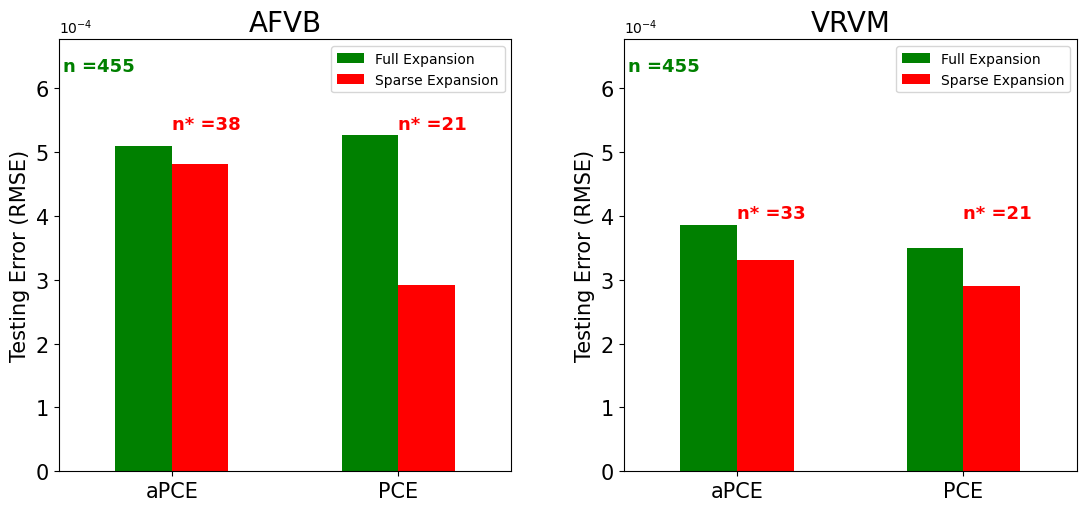

In [34]:
plot_Error(Error_AFVB_Ishigami, Error_AFVB_PCE_Ishigami, 
           Error_VRVM_Ishigami, Error_VRVM_PCE_Ishigami,
           10000, '$10^{-4}$', mod_AFVB_Ishigami.n)
#plt.savefig(wd + '/RMSE_Ishigami.png')

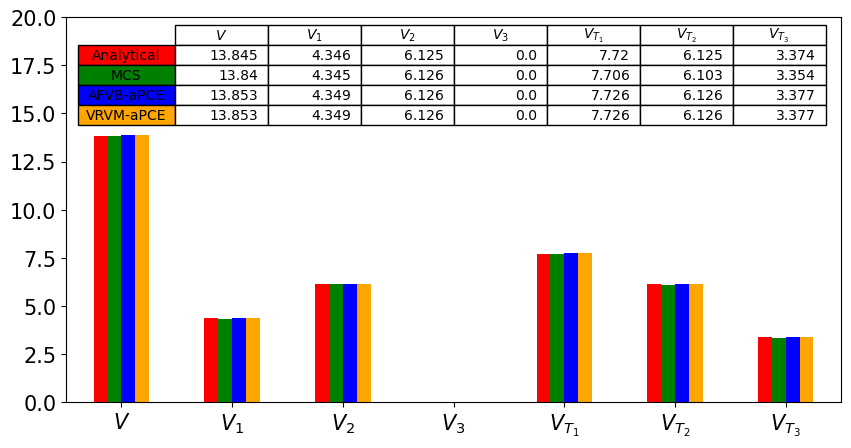

In [163]:
l = ['$V$', '$V_1$', '$V_2$','$V_3$', '$V_{T_1}$','$V_{T_2}$','$V_{T_3}$']
plot_Variances(GSA_Ishigami, Sobol_MC_Ishigami, GSA_AFVB_Ishigami, 
               V_Ishigami, V_MC_Ishigami, V_AFVB_Ishigami, V_VRVM_Ishigami,
               GSA_VRVM_Ishigami, l, 20, (10,5), 1);

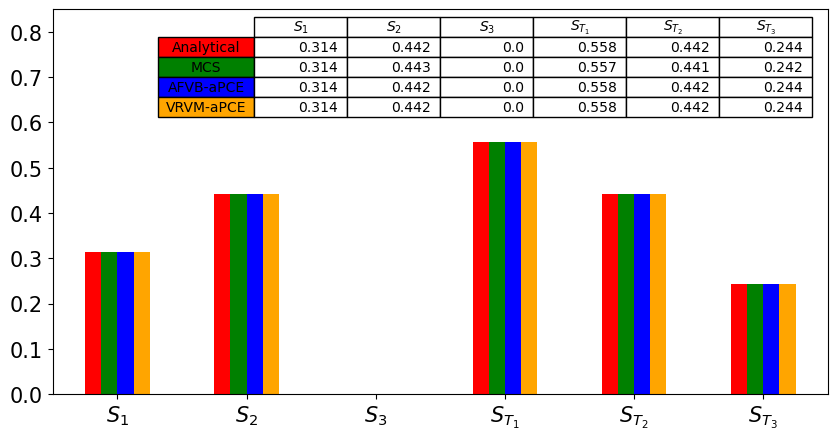

In [164]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Ishigami, Sobol_MC_Ishigami, 
           GSA_AFVB_Ishigami, GSA_VRVM_Ishigami, l, 0.85, (10,5), 1);
#plt.savefig(wd + '/GSA_Ishigami.png')

### For the following plots we can:
* Plot the full expansion coefficients with the sparse expansion coefficients
* Plot the coeffients of both sparse models, AFVB and VRVM
* Plot the coefficients of one model for PCE and aPCE

Question: Why plot the x-axis with a log scale?

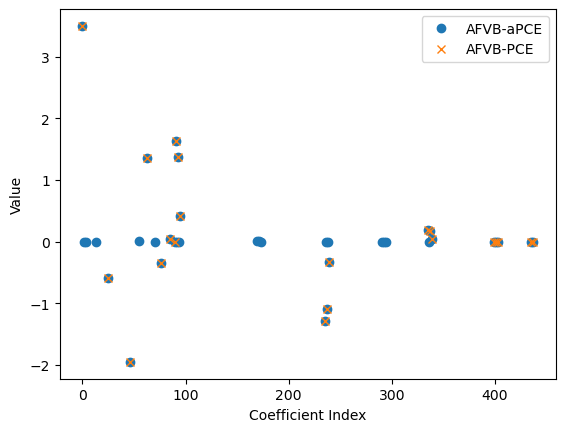

In [165]:
plt.plot(mod_AFVB_Ishigami.active_cols, mod_AFVB_Ishigami.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Ishigami.active_cols, mod_AFVB_PCE_Ishigami.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Ishigami.png')

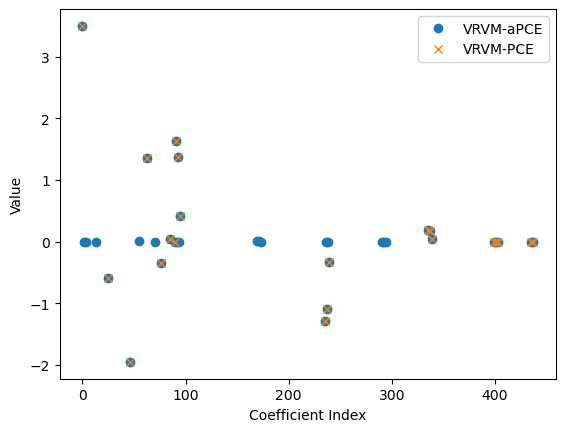

In [166]:
plt.plot(mod_VRVM_Ishigami.active_cols, mod_VRVM_Ishigami.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Ishigami.active_cols, mod_VRVM_PCE_Ishigami.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Ishigami.png')

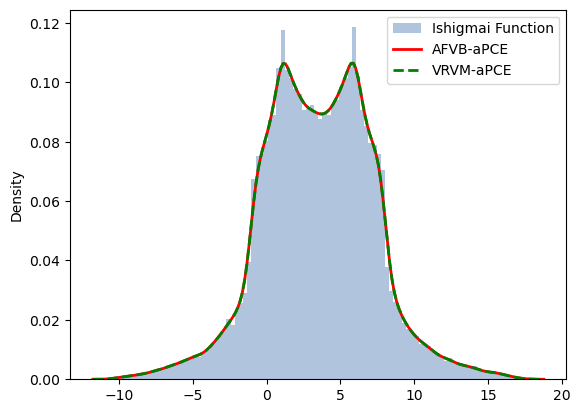

In [35]:
plt.hist(Ishigami_Function(X_dens).reshape(N_dens), density = True, bins = 100, color = 'lightsteelblue', label='Ishigmai Function')
sns.kdeplot((mod_AFVB_Ishigami.predict(X_dens, mod_AFVB_Ishigami.active_cols)).reshape(N_dens), 
            lw=2, color='r', label='AFVB-aPCE')
sns.kdeplot((mod_VRVM_Ishigami.predict(X_dens, mod_VRVM_Ishigami.active_cols)).reshape(N_dens), 
            lw=2, linestyle="--", color='g', label='VRVM-aPCE')
plt.legend();
#plt.savefig(wd + '/Density_Ishigami.png')

## Running with different values of N_pol

In [15]:
np.random.seed(100)

N_pol = N_train
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA, mod_save = Results(Ishigami_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2, mod_save = Results(Ishigami_Function, X_train, X_test, 
            AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

In [16]:
Res_Error

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,320,49,0.000081,0.000315,0.000837,0.000669,0.852478
1,5000,45,0.000081,0.000298,0.000749,0.000650,0.640837
2,10000,44,0.000091,0.000273,0.000748,0.000650,0.773641
3,50000,46,0.000091,0.000275,0.000722,0.000649,0.783967
4,100000,44,0.000087,0.000270,0.000763,0.000567,0.820247
5,500000,43,0.000095,0.000280,0.000716,0.000587,0.999585
6,1000000,42,0.000092,0.000278,0.000662,0.000563,1.306579
7,5000000,37,0.000089,0.000275,0.000689,0.000553,1.434395
8,10000000,35,0.000092,0.000296,0.000721,0.000552,1.278801


In [17]:
Res_GSA

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.332465,4.399501,6.370637,2.483159e-03,7.959345,6.370637,3.562328,0.306960,0.444490,1.732542e-04,0.555337,0.444490,0.248550
1,14.116932,4.482868,6.094916,1.179173e-07,8.022015,6.094916,3.539147,0.317553,0.431745,8.352898e-09,0.568255,0.431745,0.250702
2,13.773153,4.383211,6.004761,8.230918e-05,7.768310,6.004761,3.385182,0.318243,0.435976,5.976059e-06,0.564018,0.435976,0.245781
3,13.804783,4.337431,6.115694,7.273424e-05,7.689016,6.115694,3.351658,0.314198,0.443013,5.268771e-06,0.556982,0.443013,0.242790
4,13.862851,4.362146,6.131230,8.412202e-06,7.731613,6.131230,3.369475,0.314664,0.442278,6.068161e-07,0.557722,0.442278,0.243058
5,13.853779,4.350173,6.127986,1.849383e-08,7.725793,6.127986,3.375620,0.314006,0.442333,1.334930e-09,0.557667,0.442333,0.243661
6,13.857016,4.350884,6.129607,5.466956e-07,7.727409,6.129607,3.376526,0.313984,0.442347,3.945262e-08,0.557653,0.442347,0.243669
7,13.840739,4.343700,6.123285,1.120902e-06,7.717454,6.123285,3.373755,0.313834,0.442410,8.098572e-08,0.557590,0.442410,0.243755
8,13.850794,4.349116,6.124486,1.455865e-07,7.726307,6.124486,3.377192,0.313998,0.442176,1.051106e-08,0.557824,0.442176,0.243827


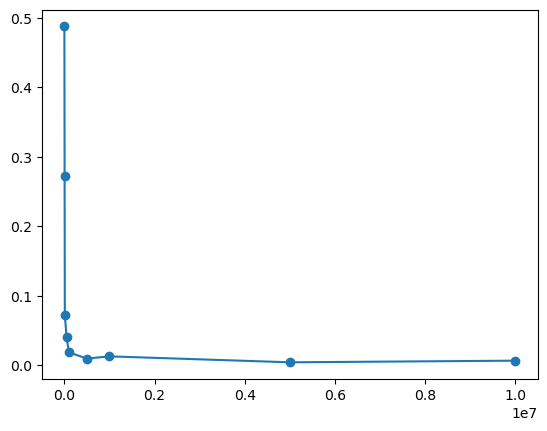

In [18]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-')

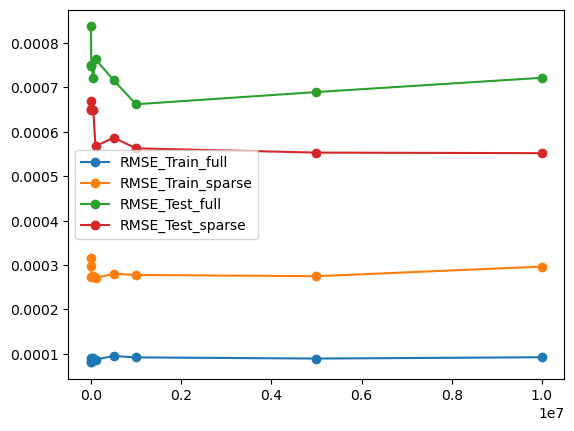

In [19]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

## Running with different values of N_pol

In [21]:
np.random.seed(100)

N_pol = 1000
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA = Results(Ishigami_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))
    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2 = Results(Ishigami_Function, X_train, X_test, 
            SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

KeyboardInterrupt: 

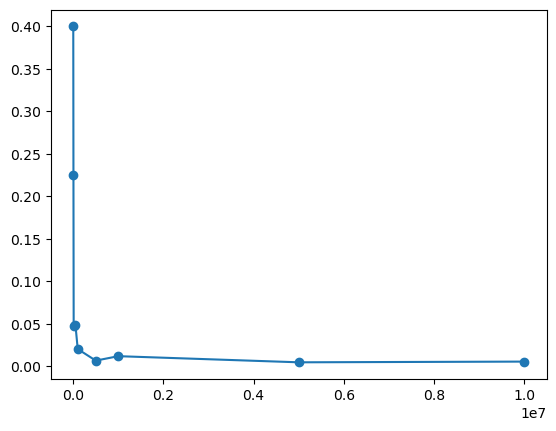

In [25]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-');

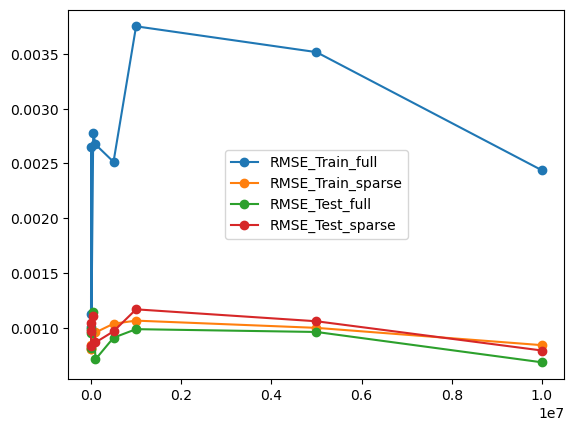

In [26]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

# Example 2: Morris Function
The morris function is given as

$$
Y = b_0 + \sum_{i=1}^{20}b_i \omega_i + \sum_{i<j}^{20}b_{ij}\omega_i\omega_j + \sum_{1<j<l}^{20}b_{ijl}\omega_i\omega_j\omega_l + \sum_{i<j<l<s}^{20}b_{ijls}\omega_i\omega_j\omega_l\omega_s
$$
where
$$
\omega_i = \left\{
        \begin{array}{ll}
            \frac{2.2X_i}{X_i+0.1} - 1 & \quad \text{if } i=3,5,7 \\
            2X_i - 1 & \quad \text{otherwise}
        \end{array}
    \right.
$$
The coefficients are given by

* $X_i \sim \mathcal{U}(0,1)$ for $i=1,\dots,20$
* $b_i = 20$ for $i=1,\dots, 10$
* $b_{ij} = -15$ for $i,j=1,\dots, 6 \phantom{xx} i<j$
* $b_{ijl} = -10$ for $i,j,l = 1,\dots, 5 \phantom{xx} i<j<l$
* $b_{ijls} = 5$ for $i,j,l,s = 1,\dots, 4 \phantom{xx} i<j<l<s$

The remaining coefficients are defined by

* $b_0 = 0$
* $b_i = (-1)^i$
* $b_{ij} = (-1)^{i+j}$
* 0 for all other

In [149]:
d = 20  # d --> number of random variables
p = 2 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [150]:
#np.random.seed(123)
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [151]:
def Morris_Function(X):
    
    N = X.shape[0]
    d = X.shape[1]
    # Making indexes for the sums
    index2 = []
    for j in range(1,20):
        for i in range(j):
            index2.append([i,j])
    index2 = np.array(index2)
    
    index3 = []
    for l in range(2,5):
        for j in range(1,l):
            for i in range(j):
                index3.append([i,j,l])
    index3 = np.array(index3)
    
    # Creating omega
    omega = np.zeros((N, d))
    for i in range(d):
        omega[:,i] = 2*X[:,i] - 1
    for i in [2,4,6]:
        omega[:,i] = 2.4*X[:,i]/(X[:,i] + 1) - 1
        
    # Sum with one index
    s1_1_to_10 = np.sum(20*omega[:,0:10], axis = 1)
    s1_11_to_20 = np.sum(omega[:,10:20], axis = 1)

    s1 = s1_1_to_10 + s1_11_to_20
    
    # Sum with two index
    s2_1_to_6 = np.zeros(N)
    s2_7_to_20 = np.zeros(N)
    for k in range(index2.shape[0]):
        if index2[k][1] <= 5:
            s2_1_to_6 += -15*omega[:,index2[k][0]]*omega[:,index2[k][1]]
        else:
            s2_7_to_20 += (-1)**(index2[k][0] + index2[k][1] + 2)\
            *omega[:,index2[k][0]]*omega[:,index2[k][1]]

    s2 = s2_1_to_6 + s2_7_to_20
    
    # Sum with three index
    s3 = np.zeros(N)
    for k in range(index3.shape[0]):
        s3 += (-10)*omega[:,index3[k][0]]*omega[:,index3[k][1]]*omega[:,index3[k][2]]
    
    # Sum with four index
    s4 = 5*omega[:,0]*omega[:,1]*omega[:,2]*omega[:,3]
    
    return s1 + s2 + s3 + s4

In [154]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [155]:
def basis_PCE_Morris(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [152]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Morris, V_MC_Morris = MC_Sobol(Morris_Function, dataA, dataB)

In [153]:
Sobol_MC_Morris

,Partial Variance,Total Variance,1st Order,Total Order
0,241.1771,311.9602,0.1350,0.1746
1,251.6403,320.8458,0.1408,0.1796
2,62.8365,97.1501,0.0352,0.0544
3,251.2231,321.8683,0.1406,0.1802
4,62.8270,97.4105,0.0352,0.0545
5,264.7096,357.8874,0.1482,0.2003
6,42.1714,43.6586,0.0236,0.0244
7,143.4512,146.1343,0.0803,0.0818
8,122.3982,124.7577,0.0685,0.0698
9,143.8378,146.6167,0.0805,0.0821


# AFVB

In [159]:
Error_AFVB_Morris, GSA_AFVB_Morris, mod_AFVB_Morris, V_AFVB_Morris = Results(Morris_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [161]:
Error_AFVB_PCE_Morris, GSA_AFVB_PCE_Morris, mod_AFVB_PCE_Morris, V_AFVB_PCE_Morris = Results(Morris_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Morris, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [165]:
Error_AFVB_PCE_Morris

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,35,2.305231,4.986334,5.105847,5.800985,9.171666


# VRVM

In [166]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Morris_Function(X_train).reshape(N_train)

In [167]:
Error_VRVM_Morris, GSA_VRVM_Morris, mod_VRVM_Morris, V_VRVM_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

KeyboardInterrupt: 

In [ ]:
Error_VRVM_PCE_Morris, GSA_VRVM_PCE_Morris, mod_VRVM_PCE_Morris, V_VRVM_PCE_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Morris, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_Morris, Error_AFVB_PCE_Morris, 
           Error_VRVM_Morris, Error_VRVM_PCE_Morris,
           10000, '$10^{-4}$')
#plt.savefig(wd + '/RMSE_Morris.png')

In [ ]:
#l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Morris, Sobol_MC_Morris, 
           GSA_AFVB_Morris, GSA_VRVM_Morris, l, 0.85);
#plt.savefig(wd + '/GSA_Morris.png')

In [ ]:
plt.plot(mod_AFVB_Morris.active_cols, mod_AFVB_Morris.a_hat, 'o')
plt.plot(mod_AFVB_PCE_Morris.active_cols, mod_AFVB_PCE_Morris.a_hat, 'x')

# Example 3: Borehole Function
 

$$
f(x) = \frac{2\pi*T_u(H_u-H_l)}{\ln(r/r_w)\left(1+\frac{2LT_u}{\ln(r/r_w)r_w^2K_w}+\frac{T_u}{T_l}\right)}
$$

* $r_w \sim \mathcal{N}(0.1, 0.0161812)$
* $r \sim \text{Lognormal}(7.71, 1.0056)$
* $T_u \sim \mathcal{U}(63070, 115600)$
* $H_u \sim \mathcal{U}(990, 1110)$
* $T_l \sim \mathcal{U}(63.1, 116)$
* $H_l \sim \mathcal{U}(700, 820)$
* $L \sim \mathcal{U}(1120, 1680)$
* $K_w \sim \mathcal{U}(9855, 12045)$

In [865]:
d = 8  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [866]:
#np.random.seed(123)
def make_data_borehole(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.normal(0.1, 0.0161812, size = N)
    X[:,1] = np.random.lognormal(7.71, 1.0056, size = N)
    X[:,2] = np.random.uniform(63070, 115600, size = N)
    X[:,3] = np.random.uniform(990, 1110, size = N)
    X[:,4] = np.random.uniform(63.1, 116, size = N)
    X[:,5] = np.random.uniform(700, 820, size = N)
    X[:,6] = np.random.uniform(1120, 1680, size = N)
    X[:,7] = np.random.uniform(9855, 12045, size = N)
    return X

In [867]:
X_train = make_data_borehole(N_train)
X_test = make_data_borehole(N_test)
X_pol = make_data_borehole(N_pol)

idx = multivariate_pce_index(d, p)

In [868]:
def Borehole_Function(X):
    r_w = X[:,0]
    r = X[:,1]
    T_u = X[:,2]
    H_u = X[:,3]
    T_l = X[:,4]
    H_l = X[:,5]
    L = X[:,6]
    K_w = X[:,7]
    
    return (2*np.pi*T_u*(H_u-H_l))/(np.log(r/r_w)*(1 + (2*L*T_u)/(np.log(r/r_w)*r_w**2*K_w) + T_u/T_l))

In [869]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [870]:
def basis_PCE_Borehole(Z, p):
    "Z as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    a_val = [0, 0, 63070, 990, 63.1, 700, 1120, 9855]
    b_val = [0, 0, 115600, 1110, 116, 820, 1680, 12045]
    
    for i in range(n):
        
        Phi[:,i] *= hermitenorm(idx[i][0])((Z[:,0] - 0.1)/0.0161812)
        Phi[:,i] *= hermitenorm(idx[i][1])((np.log(Z[:,1]) - 7.71)/1.0056)
        
        for j in range(2, d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])((a_val[j]+b_val[j]-2*Z[:,j])/(a_val[j]-b_val[j]))
                    
    return Phi

# MC Sobol Indices

In [871]:
dataA = pd.DataFrame(make_data_borehole(N_mc)).values
dataB = pd.DataFrame(make_data_borehole(N_mc)).values

Sobol_MC_Borehole, V_MC_Borehole = MC_Sobol(Borehole_Function, dataA, dataB)

# AFVB

In [872]:
Error_AFVB_Borehole, GSA_AFVB_Borehole, mod_AFVB_Borehole, V_AFVB_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [875]:
Error_AFVB_PCE_Borehole, GSA_AFVB_PCE_Borehole, mod_AFVB_PCE_Borehole, V_AFVB_PCE_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Borehole, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [876]:
a_0 = 0.3
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Borehole_Function(X_train).reshape(N_train)

In [877]:
Error_VRVM_Borehole, GSA_VRVM_Borehole, mod_VRVM_Borehole, V_VRVM_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [878]:
Error_VRVM_PCE_Borehole, GSA_VRVM_PCE_Borehole, mod_VRVM_PCE_Borehole, V_VRVM_PCE_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Borehole, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

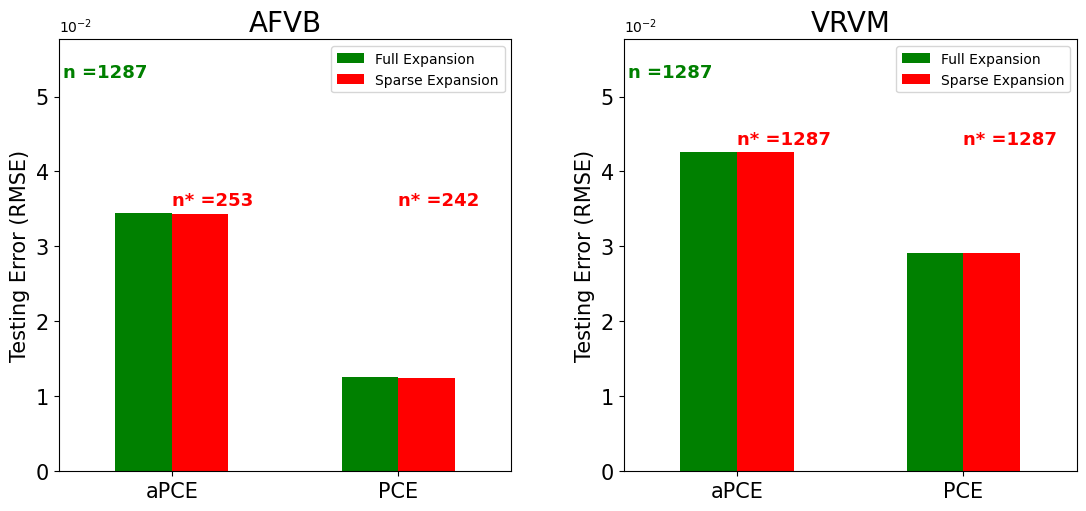

In [879]:
plot_Error(Error_AFVB_Borehole, Error_AFVB_PCE_Borehole, 
           Error_VRVM_Borehole, Error_VRVM_PCE_Borehole,
           100, '$10^{-2}$', mod_AFVB_Borehole.n)
#plt.savefig(wd + '/RMSE_Borehole.png')

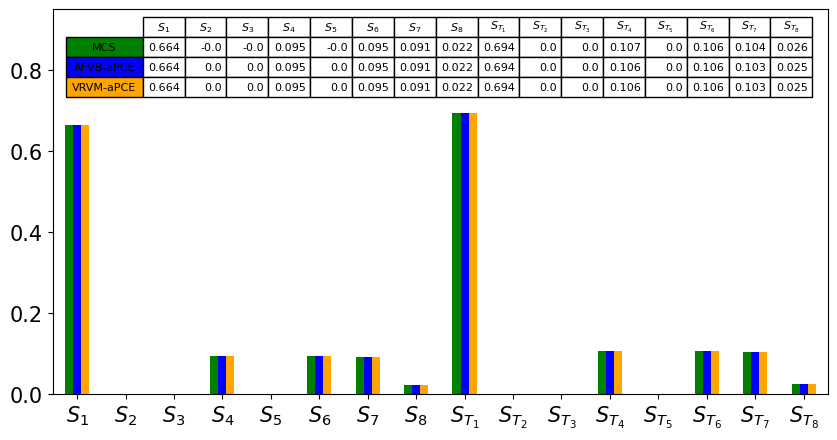

In [880]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(Sobol_MC_Borehole, 
           GSA_AFVB_Borehole, GSA_VRVM_Borehole, GSA4 = None,
                   l=l, ylimit=0.95, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Borehole.png')

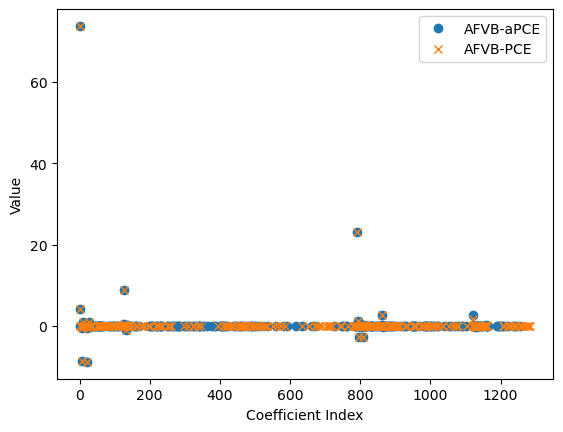

In [881]:
plt.plot(mod_AFVB_Borehole.active_cols, mod_AFVB_Borehole.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Borehole.active_cols, mod_AFVB_PCE_Borehole.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Borehole.png')

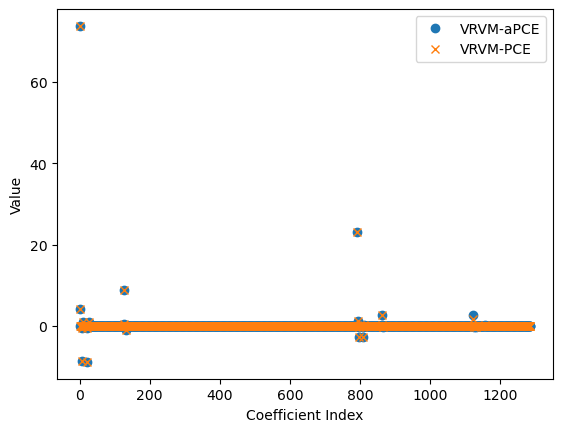

In [882]:
plt.plot(mod_VRVM_Borehole.active_cols, mod_VRVM_Borehole.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Borehole.active_cols, mod_VRVM_PCE_Borehole.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Borehole.png')

# Example 4: 1-dof Undamped Oscillator 

The performance function is

$$
G(X) = 3r-\left| \frac{2 F_1}{m\omega_0^2}\sin\left( \frac{\omega_0^2t_1}{2} \right) \right|
$$

where $\omega_0=\sqrt{\frac{c_1+c_2}{m}}$. The distribution of the random variables are as follow:

\begin{align*}
m &\sim \text{LogNormal}(1, 0.15^2) && \text{Mass} \\
c_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Stiffness of spring one} \\
c_2 &\sim \text{LogNormal}(0.1, 0.02^2) && \text{Stiffness of spring two} \\
r &\sim \text{LogNormal}(0.5, 0.1^2) && \text{Displacement yielded by one of the springs} \\
F_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Exciting force} \\
t_1 &\sim \text{LogNormal}(1, 0.1^2) && \text{Excitation time} 
\end{align*}

In [235]:
d = 6  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [236]:
#np.random.seed(123)
def make_data_oscillator(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.lognormal(1, 0.15, size = N)
    X[:,1] = np.random.lognormal(1, 0.2, size = N)
    X[:,2] = np.random.lognormal(0.1, 0.02, size = N)
    X[:,3] = np.random.lognormal(0.5, 0.1, size = N)
    X[:,4] = np.random.lognormal(1, 0.2, size = N)
    X[:,5] = np.random.lognormal(1, 0.1, size = N)
    return X

In [237]:
X_train = make_data_oscillator(N_train)
X_test = make_data_oscillator(N_test)
X_pol = make_data_oscillator(N_pol)

idx = multivariate_pce_index(d, p)

In [238]:
def Oscillator_Function(X):
    m = X[:,0]
    c1 = X[:,1]
    c2 = X[:,2]
    r = X[:,3]
    F1 = X[:,4]
    t1 = X[:,5]
    
    w0 = np.sqrt((c1+c2)/m)
    
    return 3*r - np.abs(2*F1/(m*w0**2)*np.sin(w0**2*t1/2))

In [239]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [240]:
def basis_PCE_Oscillator(Z, p):
    "Z ~ LogNormal(.,.) as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [1, 1, 0.1, 0.5, 1, 1]
    sigma_vals = [0.15, 0.2, 0.02, 0.1, 0.2, 0.1]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((np.log(Z[:,j]) - mu_vals[j])/sigma_vals[j])
                    
    return Phi

## AFVB

In [241]:
Error_AFVB_Oscillator, GSA_AFVB_Oscillator, mod_AFVB_Oscillator, V_AFVB_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [242]:
Error_AFVB_PCE_Oscillator, GSA_AFVB_PCE_Oscillator, mod_AFVB_PCE_Oscillator, V_AFVB_PCE_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Oscillator, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

## VRVM

In [243]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Oscillator_Function(X_train).reshape(N_train)

In [244]:
Error_VRVM_Oscillator, GSA_VRVM_Oscillator, mod_VRVM_Oscillator, V_VRVM_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [245]:
Error_VRVM_PCE_Oscillator, GSA_VRVM_PCE_Oscillator, mod_VRVM_PCE_Oscillator, V_VRVM_PCE_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Oscillator, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

## MC Sobol Indices

In [247]:
dataA = pd.DataFrame(make_data_oscillator(N_mc)).values
dataB = pd.DataFrame(make_data_oscillator(N_mc)).values

Sobol_MC_Oscillator = MC_Sobol(Oscillator_Function, dataA, dataB)

# Plots

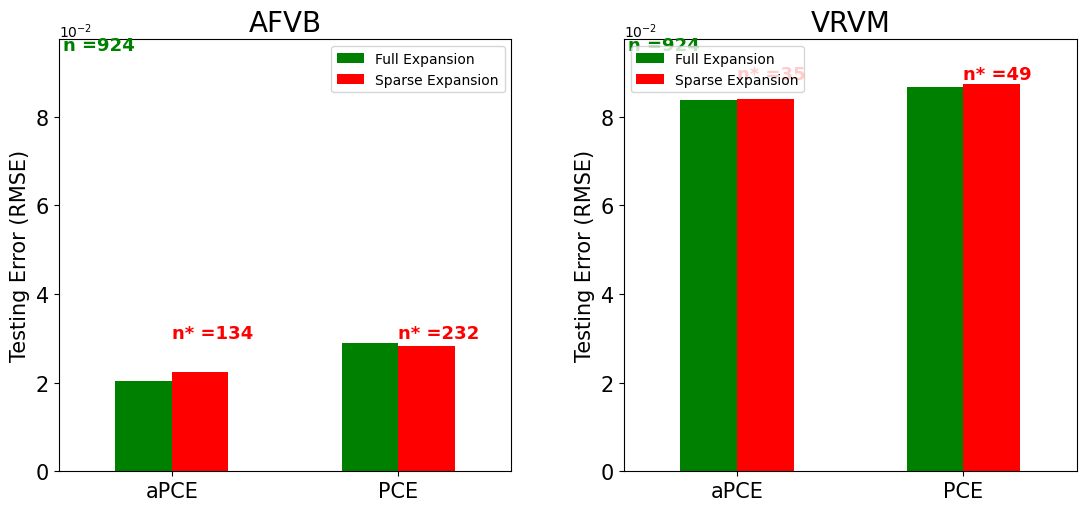

In [494]:
plot_Error(Error_AFVB_Oscillator, Error_AFVB_PCE_Oscillator, 
           Error_VRVM_Oscillator, Error_VRVM_PCE_Oscillator,
           100, '$10^{-2}$', mod_AFVB_Oscillator.n)
#plt.savefig(wd + '/RMSE_Oscillator.png')

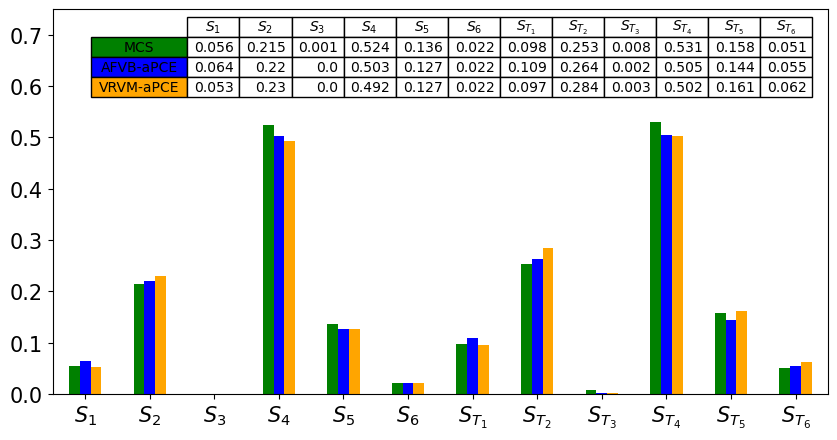

In [499]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$']

plot_Sobol_Indices(Sobol_MC_Oscillator[0], 
           GSA_AFVB_Oscillator, GSA_VRVM_Oscillator, GSA4 = None,
                   l=l, ylimit=0.75, fig_size=(10,5), table_size=0.56);
#plt.savefig(wd + '/GSA_Oscillator.png')

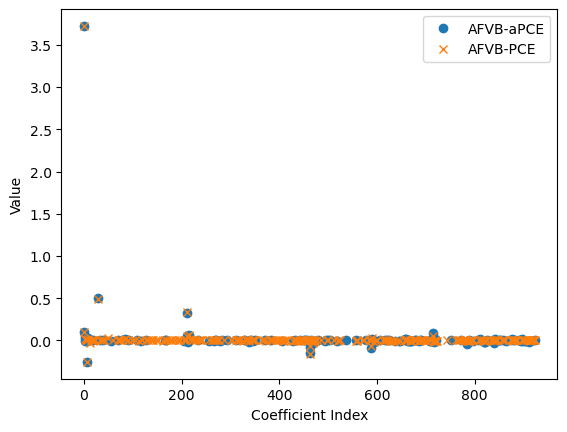

In [500]:
plt.plot(mod_AFVB_Oscillator.active_cols, mod_AFVB_Oscillator.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Oscillator.active_cols, mod_AFVB_PCE_Oscillator.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Oscillator.png')

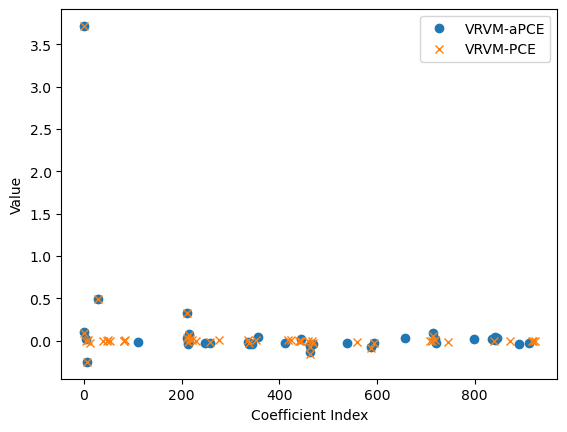

In [501]:
plt.plot(mod_VRVM_Oscillator.active_cols, mod_VRVM_Oscillator.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Oscillator.active_cols, mod_VRVM_PCE_Oscillator.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Oscillator.png')

# Example 5: Cantilever Tube Structure

A **cantilever** is a rigid structural element that extends horizontally and is supported at only one end. The structure is subjected to three random external forces $(F_1, F_2, P)$ and a random torque $T$. The structure fails when the maximum Von Mises stress $\sigma_{max}$ at the fixed end of the tube is greater than the yield strength $R$. The limit state function of the structure is expressed as:

$$
G = R-\sigma_{max} = R-\sqrt{\sigma_x^2+3\tau^2_{zx}}
$$

where 

\begin{align*}
\sigma_x &= \frac{F_1\sin\theta_1+F_2\sin\theta_2+P}{A} + \frac{Md}{2I} \\
M &= F_1\cos\theta_1L_1 + F_2\cos\theta_2L_2 \\
A &= \frac{\pi}{4}\left[d^2 - (d-2h)^2\right] \\
I &= \frac{\pi}{64}\left[d^4-(d-2h)^4\right] \\
\tau_{zx} &= \frac{Td}{4I}
\end{align*}

The **limit state function** $G(X)$ defines a failure criterion that is a function of all random variables $X$. Failure occurs when the load $L$ exceeds the capacity $R$ or when $G(X)<0$. The parameters have the following values:

\begin{align*}
L_1 &= 60 && \text{(mm)} \\
L_2 &= 120 && \text{(mm)} \\
\theta_1 &= 10^{\circ} = \frac{\pi}{18} \\
\theta_2 &= 5^{\circ} = \frac{\pi}{36} \\
d &\sim \mathcal{N}(42, 0.4998^2) && \text{(mm)} \\
h &\sim \mathcal{N}(5, 0.1^2) && \text{(mm)} \\
R_0 &\sim \mathcal{N}(560, 56^2) && \text{(MPa)} \\
F_1 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
F_2 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
P &\sim \mathcal{N}(1000, 100^2) && \text{(N)} \\
T &\sim \mathcal{N}(1900, 190^2) && \text{(Nm)} 
\end{align*}

In [254]:
d = 7  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

In [255]:
# From first paper
L1 = 0.06
L2 = 0.12
Theta1 = 10
Theta2 = 5

D_mu = 0.042
h_mu = 0.005
R0_mu = 560
F_mu = 1800
P_mu = 1000
T_mu = 1900

In [256]:
def make_data_cantilever(N):
    X = np.zeros((N, d))

    # D, h, R0, F1, F2, P, T
    X[:,0] = np.random.normal(D_mu, D_mu*0.0119, N)
    X[:,1] = np.random.normal(h_mu, h_mu*0.02, N)
    X[:,2] = np.random.normal(R0_mu, R0_mu*0.1, N)
    X[:,3] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,4] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,5] = np.random.normal(P_mu, P_mu*0.1, N)
    X[:,6] = np.random.normal(T_mu, T_mu*0.1, N)
    
    return X

In [257]:
#np.random.seed(100)
X_test = make_data_cantilever(N_test)
X_train = make_data_cantilever(N_train)
X_pol = make_data_cantilever(N_pol)

idx = multivariate_pce_index(d, p)

In [258]:
def Cantilever_Function(X):
    
    D = X[:,0]
    h = X[:,1]
    R0 = X[:,2]
    F1 = X[:,3]
    F2 = X[:,4]
    P = X[:,5]
    T = X[:,6]
    
    
    M = F1*np.cos(Theta1)*L1 + F2*np.cos(Theta2)*L2
    A = np.pi/4*(D**2 - (D - 2*h)**2)
    I = np.pi/64*(D**4 - (D - 2*h)**4)
    sigma_x = (F1*np.sin(Theta1) + F2*np.sin(Theta2) + P)/A + M*D/(2*I)
    tau_zx = T*D/(4*I)
    
    return R0/(np.sqrt(sigma_x**2 + 3*tau_zx**2)*10**(-6)) # Units in MPa

In [259]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [260]:
def basis_PCE_Cantilever(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-mu_vals[j])/sigma_vals[j])
                    
    return Phi

# MC Sobol Indices

In [261]:
dataA = pd.DataFrame(make_data_cantilever(N_mc)).values
dataB = pd.DataFrame(make_data_cantilever(N_mc)).values

Sobol_MC_Cantilever = MC_Sobol(Cantilever_Function, dataA, dataB)

## AFVB

In [262]:
Error_AFVB_Cantilever, GSA_AFVB_Cantilever, mod_AFVB_Cantilever, V_AFVB_Cantilever = Results(Cantilever_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [263]:
Error_AFVB_PCE_Cantilever, GSA_AFVB_PCE_Cantilever, mod_AFVB_PCE_Cantilever, V_AFVB_PCE_Cantilever = Results(Cantilever_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Cantilever, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

## VRVM

In [312]:
a_0 = 0.2
b_0 = 1.0

data={'xi': X_train}
data['y'] = Cantilever_Function(X_train).reshape(N_train)

In [265]:
Error_VRVM_Cantilever, GSA_VRVM_Cantilever, mod_VRVM_Cantilever, V_VRVM_Cantilever = Results(Cantilever_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [268]:
Error_VRVM_PCE_Cantilever, GSA_VRVM_PCE_Cantilever, mod_VRVM_PCE_Cantilever, V_VRVM_Cantilever = Results(Cantilever_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Cantilever, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

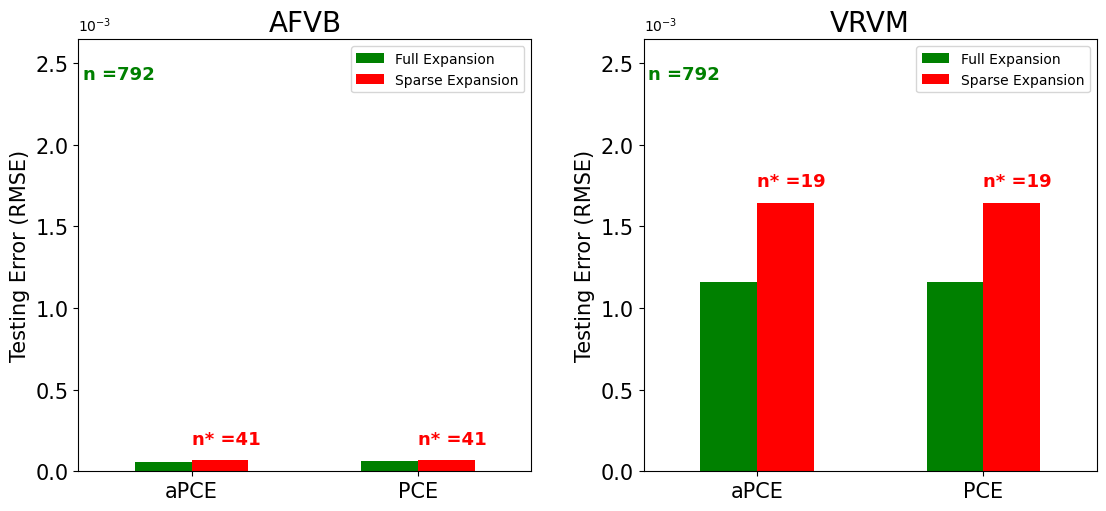

In [503]:
plot_Error(Error_AFVB_Cantilever, Error_AFVB_PCE_Cantilever, 
           Error_VRVM_Cantilever, Error_VRVM_PCE_Cantilever,
           1000, '$10^{-3}$', mod_AFVB_Cantilever.n)
#plt.savefig(wd + '/RMSE_Cantilever.png')

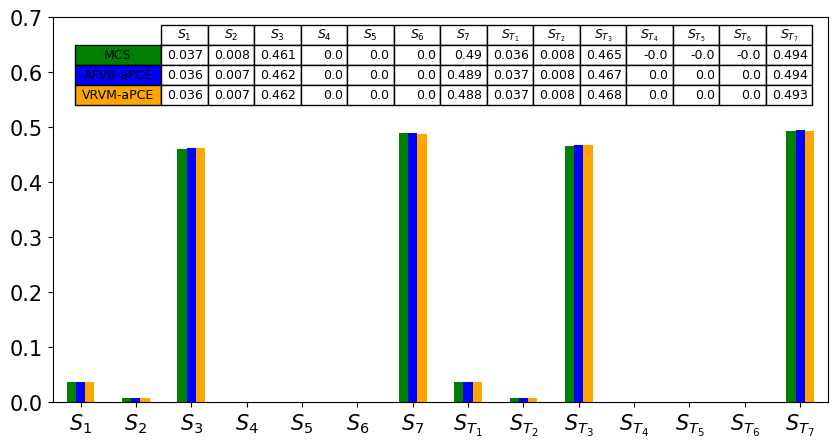

In [506]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$']

plot_Sobol_Indices(Sobol_MC_Cantilever[0], 
           GSA_AFVB_Cantilever, GSA_VRVM_Cantilever, GSA4 = None,
                   l=l, ylimit=0.7, fig_size=(10,5), table_size=0.5);
#plt.savefig(wd + '/GSA_Cantilever.png')

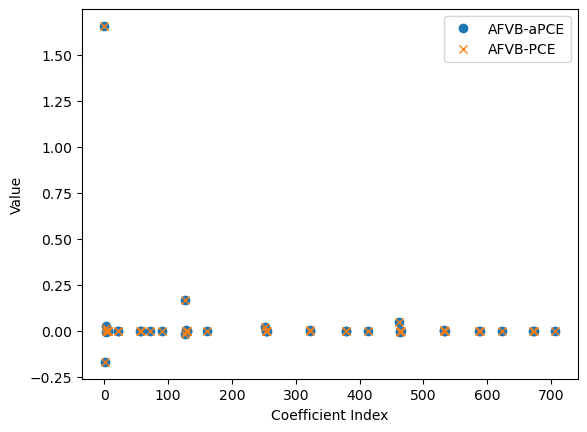

In [507]:
plt.plot(mod_AFVB_Cantilever.active_cols, mod_AFVB_Cantilever.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Cantilever.active_cols, mod_AFVB_PCE_Cantilever.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Cantilever.png')

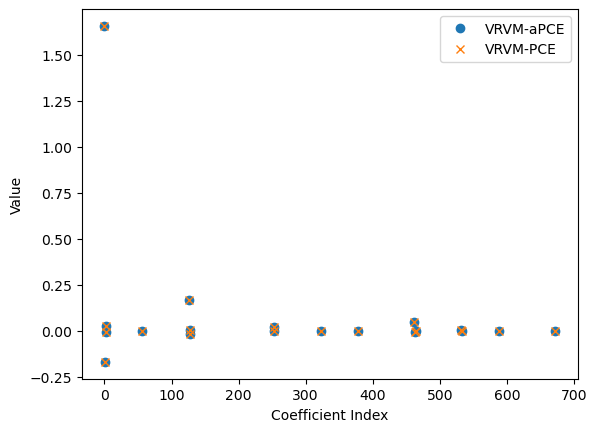

In [508]:
plt.plot(mod_VRVM_Cantilever.active_cols, mod_VRVM_Cantilever.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Cantilever.active_cols, mod_VRVM_PCE_Cantilever.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Cantilever.png')

# Example 6: Sobol' function

The Sobol function is given by

$$
Y = \prod_{i=1}^d\frac{|4\xi_i - 2| + a_i}{1 + a_i}
$$

where $\xi_i$ are independent random variables uniformly distributed over $[0,1]$ and $a_i$ are the constants. 


In [302]:
d = 8  # d --> number of random variables
p = 5  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [303]:
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [304]:
def Sobol_Function(Z):
    alpha = np.c_[1, 2, 5, 10, 20, 50, 100, 500]
    return np.c_[np.prod((np.abs(4*Z - 2) + alpha)/(1 + alpha),1)]

In [305]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [306]:
def basis_PCE_Sobol(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [307]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Sobol = MC_Sobol(Sobol_Function, dataA, dataB)

In [308]:
# Analytical Sobol Indices
GSA_Sobol = ([0.6037, 0.2683, 0.0671, 0.0200, 0.0055, 0.0009, 0.0002, 0.0000], 
             [0.6342, 0.2945, 0.0756, 0.0227, 0.0062, 0.0011, 0.003, 0.0000])

GSA_Sobol = pd.DataFrame(GSA_Sobol).T
GSA_Sobol.columns = ['1st Order', 'Total Order']

# AFVB

In [309]:
Error_AFVB_Sobol, GSA_AFVB_Sobol, mod_AFVB_Sobol, V_AFVB_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [311]:
Error_AFVB_PCE_Sobol, GSA_AFVB_PCE_Sobol, mod_AFVB_PCE_Sobol, V_AFVB_PCE_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Sobol, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [313]:
data={'xi': X_train}
data['y'] = Sobol_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [314]:
Error_VRVM_Sobol, GSA_VRVM_Sobol, mod_VRVM_Sobol, V_VRVM_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [315]:
Error_VRVM_PCE_Sobol, GSA_VRVM_PCE_Sobol, mod_VRVM_PCE_Sobol, V_VRVM_PCE_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Sobol, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

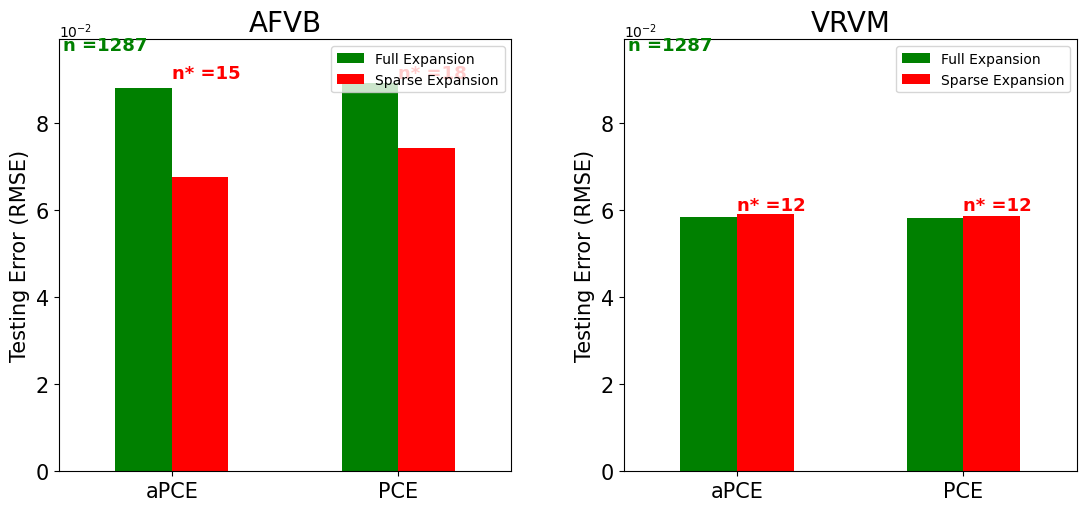

In [510]:
plot_Error(Error_AFVB_Sobol, Error_AFVB_PCE_Sobol, 
           Error_VRVM_Sobol, Error_VRVM_PCE_Sobol,
           100, '$10^{-2}$', mod_AFVB_Sobol.n)
#plt.savefig(wd + '/RMSE_Sobol.png')

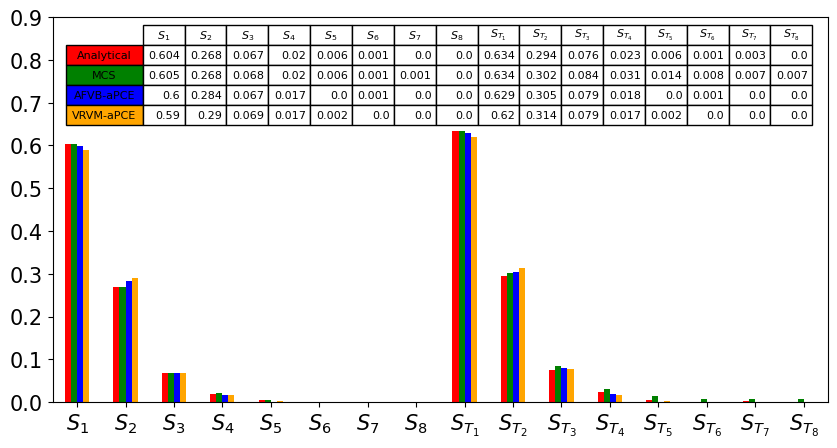

In [511]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(GSA_Sobol, Sobol_MC_Sobol[0], 
           GSA_AFVB_Sobol, GSA_VRVM_Sobol,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Sobol.png')

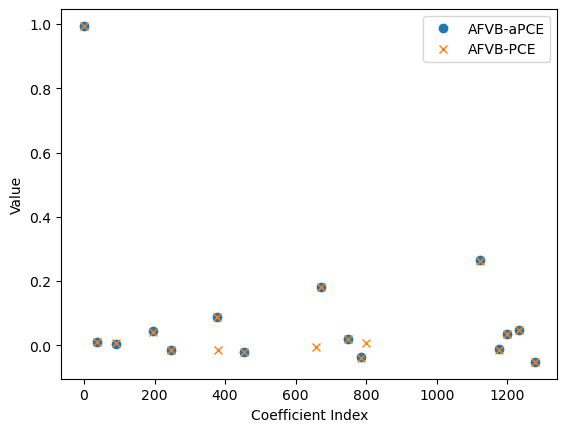

In [512]:
plt.plot(mod_AFVB_Sobol.active_cols, mod_AFVB_Sobol.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Sobol.active_cols, mod_AFVB_PCE_Sobol.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Sobol.png')

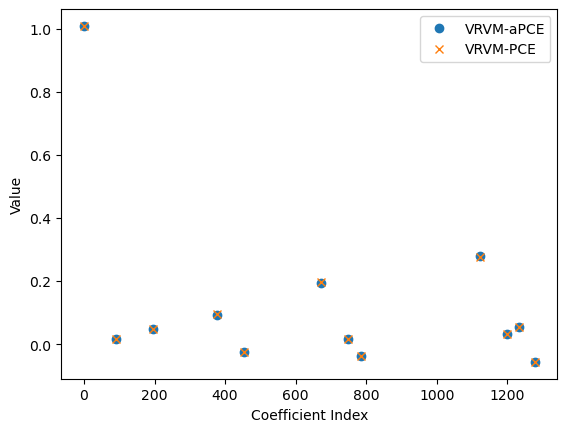

In [513]:
plt.plot(mod_VRVM_Sobol.active_cols, mod_VRVM_Sobol.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Sobol.active_cols, mod_VRVM_PCE_Sobol.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Sobol.png')

In [514]:
sns.kdeplot(mod_AFVB_PCE.Sobol.predict(X_test, active_cols_pce).reshape(N_test), color='b', label='AFVB_PCE')
sns.kdeplot(mod_AFVB.predict(X_test, active_cols).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Sobol_Function(X_test).reshape(N_test), color='r', label='Sobol Function')
plt.legend();

NameError: name 'mod_AFVB_pce' is not defined

# Example 7: PDE

In [602]:
d = 2  # d --> number of random variables
p = 12  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [ ]:
X_train = np.random.normal(9/10, 1/4, size=(N_train, d))
X_test = np.random.normal(9/10, 1/4, size=(N_test, d))
X_pol = np.random.normal(9/10, 1/4, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [ ]:
def PDE_Function(Z, t = 1):
    
    return -np.exp(-Z[:,0])*(t + (t - t**2/2)*np.exp(Z[:,1]))

In [ ]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [ ]:
def basis_PCE_PDE(Z, p):
    "Z ~ N(9/10, 1/4)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-0.9)/0.25)
    return Phi

# MC Sobol Indices

In [ ]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_PDE = MC_Sobol(PDE_Function, dataA, dataB)

# AFVB

In [ ]:
Error_AFVB_PDE, GSA_AFVB_PDE, mod_AFVB_PDE, V_AFVB_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_PCE_PDE, GSA_AFVB_PCE_PDE, mod_AFVB_PCE_PDE, V_AFVB_PCE_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_PDE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [ ]:
data={'xi': X_train}
data['y'] = PDE_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [ ]:
Error_VRVM_PDE, GSA_VRVM_PDE, mod_VRVM_PDE, V_VRVM_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [ ]:
Error_VRVM_PCE_PDE, GSA_VRVM_PCE_PDE, mod_VRVM_PCE_PDE, V_VRVM_PCE_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_PDE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_PDE, Error_AFVB_PCE_PDE, 
           Error_VRVM_PDE, Error_VRVM_PCE_PDE,
           100, '$10^{-2}$', mod_AFVB_PDE.n)
#plt.savefig(wd + '/RMSE_PDE.png')

In [ ]:
l = ['$S_1$', '$S_2$',
     '$S_{T_1}$','$S_{T_2}$']

plot_Sobol_Indices(Sobol_MC_PDE[0], 
           GSA_AFVB_PDE, GSA_VRVM_PDE,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_PDE.png')

In [ ]:
plt.plot(mod_AFVB_PDE.active_cols, mod_AFVB_PDE.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_PDE.active_cols, mod_AFVB_PCE_PDE.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_PDE.png')

In [ ]:
plt.plot(mod_VRVM_PDE.active_cols, mod_VRVM_PDE.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_PDE.active_cols, mod_VRVM_PCE_PDE.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_PDE.png')

# Hyper-parameter Tunning

In [873]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the black box function to optimize.
def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f
# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))